<a href="https://colab.research.google.com/github/BrainConnection/Qiskit/blob/main/Open%20Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [22]:
import pennylane as qml
import pennylane.numpy as np
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import qiskit_aer.noise as noise
import qiskit

In [285]:
x = np.array([1,2,3,4,5,6,7])
x_norm =x/np.linalg.norm(x)
x_density = np.outer(x_norm,x_norm)
N = np.shape(x)[0]
num_qubits = (int)(np.log2(N))

dev1 = qml.device("default.qubit", wires=range(num_qubits+1))
dev2 = qml.device("default.mixed",wires=range(num_qubits+1))

In [286]:
def binary_encode(num):

    lst = []

    for i in range(num_qubits):
      lst.append(num % 2)
      num = num // 2

    lst.reverse()

    return lst

## 1) Real Data Amplitude Embedding (Method 1)

In [287]:
def preparing_for_battle_1(x,p,type, dev):
  """
  Conduct Amplitude Embdding

  Args
    - x (numpy.tensor): A length-N vector

  Returns
    - state (qml.measurements.StateMP): Embedded state
  """

  x = x/np.linalg.norm(x)

  def error(p,type = 1):
    if type == 1:
      for i in range(num_qubits+1):
        qml.BitFlip(p,i)
    elif type == 2:
      for i in range(num_qubits+1):
        qml.PhaseFlip(p,i)
    elif type ==3:
      qml.DepolarizingChannel(p,range(num_qubits+1))
    elif type == 4:
      qml.PhaseDamping(p, range(num_qubits))
    elif type ==5:
      qml.AmplitudeDamping(p,range(num_qubits+1))


  
  @qml.qnode(dev)
  def amplitude_embedding():


    for i in range(num_qubits):
      qml.Hadamard(i)

    for i in range(N):
      U = np.array([[x[i], -np.sqrt(1-x[i]**2)], [np.sqrt(1-x[i]**2), x[i]]])
      qml.ControlledQubitUnitary(U, control_wires=range(num_qubits), wires=num_qubits, control_values=binary_encode(i))

    
    error(p,type)


    qml.measure(num_qubits)

    return qml.probs(range(num_qubits))


  
  #print(qml.draw(amplitude_embedding)())
  #print()

  return np.sqrt(amplitude_embedding())


In [288]:
p_list = np.linspace(0.01,0.5,500)
p_list = p_list.tolist()

fidelities = []
for p in p_list: 
    x_noisy = preparing_for_battle_1(x,p,1,dev2)
    x_noisy_density = np.outer(x_noisy,x_noisy)
    F = qml.math.fidelity(x_density,x_noisy_density)
    fidelities.append(F)




QuantumFunctionError: The two states must have the same number of wires.

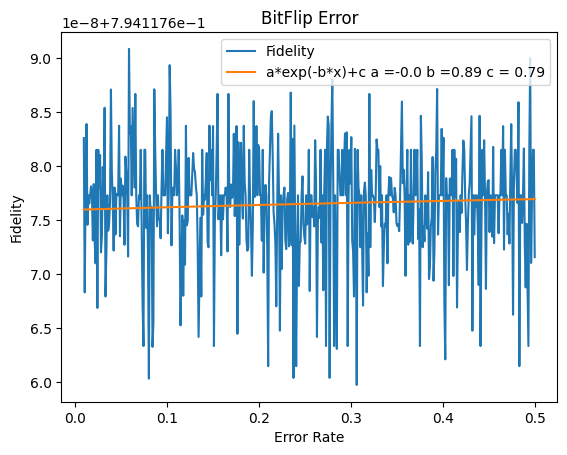

In [234]:
import matplotlib.pyplot as plt
import scipy

plt.plot(p_list,fidelities,label="Fidelity")
plt.title("BitFlip Error")
plt.ylabel("Fidelity")
plt.xlabel("Error Rate")

def exp(x,a,b,c):
    return a*np.exp(-b*x)+c

popt, pcov  = scipy.optimize.curve_fit(exp,p_list,fidelities,maxfev=50000)

plt.plot(p_list,exp(np.array(p_list),*popt),label="a*exp(-b*x)+c" + " " + "a =" + f"{round(popt[0],2)}" + " b =" +  f"{round(popt[1],2)}" + " " +  "c = " +  f"{round(popt[2],2)}")
plt.legend()


In [235]:
fidelities

[0.7941176825936035,
 0.7941176683080617,
 0.7941176780085105,
 0.7941176838880046,
 0.7941176745629115,
 0.7941176772914202,
 0.7941176765295651,
 0.7941176772914202,
 0.7941176781231456,
 0.7941176772914202,
 0.794117673114734,
 0.7941176783325867,
 0.7941176730686538,
 0.7941176709929884,
 0.7941176815013653,
 0.7941176668641357,
 0.7941176814911995,
 0.7941176780085105,
 0.794117681017595,
 0.79411767201448,
 0.7941176734976272,
 0.7941176799092861,
 0.794117676203262,
 0.7941176853935299,
 0.7941176679237634,
 0.7941176721868972,
 0.7941176772914202,
 0.7941176740199523,
 0.7941176747176731,
 0.7941176766580558,
 0.7941176870834786,
 0.794117679433178,
 0.7941176768756423,
 0.7941176721777685,
 0.7941176780085105,
 0.794117673658538,
 0.7941176774440998,
 0.7941176772914202,
 0.7941176772914202,
 0.7941176837247735,
 0.7941176734976272,
 0.7941176788326335,
 0.7941176772914202,
 0.794117678182829,
 0.7941176768756423,
 0.7941176727110761,
 0.7941176808736281,
 0.7941176795590746,


## 2) Real Data Amplitude Embedding (Method 2)

In [289]:
def preparing_for_battle_2(x,dev,verbose=False):
  """
  Conduct Amplitude Embdding

  Args
    - x (numpy.tensor): a length-N vector

  Returns
    - state (qml.measurements.StateMP): Embedded state
  """

  x = x/np.linalg.norm(x)
  N = np.shape(x)[0]
  num_qubits = (int)(np.log2(N))


  def theta_generate(x):
    y = []

    for i in range(num_qubits):
      lst = []

      for j in range(2**(i+1)):
        sum = 0

        num = (int)(N/2**(i+1))
        for k in range(j*num, (j+1)*num, 1):
          sum = sum + x[k]**2

        lst.append(np.sqrt(sum))

      y.append(lst)

    theta = []

    for i in range(num_qubits):
      lst = []

      if i==0:
        lst.append(2*np.arccos(y[i][0]))

      else:
        for j in range(2**i):
          lst.append(2*np.arccos(y[i][2*j]/y[i-1][j]))

      theta.append(lst)

    return theta


  def control_generate(num_qubits):
    control = []

    for i in range(1, num_qubits):
      lst_1 = []

      for j in range(2**i):
        lst_2 = []

        num = j
        for k in range(i):
          lst_2.append(num % 2)
          num = num // 2

        lst_2.reverse()
        lst_1.append(lst_2)

      control.append(lst_1)

    return control


  @qml.qnode(dev)
  def amplitude_embedding():

    theta = theta_generate(x)
    control_bit = control_generate(num_qubits)

    qml.RY(theta[0][0],0)

    for i in range(1, num_qubits, 1):
      for j in range(2**i):
        U = np.array([[np.cos(theta[i][j]/2), -np.sin(theta[i][j]/2)], [np.sin(theta[i][j]/2), np.cos(theta[i][j]/2)]])
        qml.ControlledQubitUnitary(U, control_wires=range(i), wires=[i], control_values=control_bit[i-1][j])


    return qml.probs(range(num_qubits))

  if verbose:
    print(qml.draw(amplitude_embedding)())
    print()

  return np.sqrt(amplitude_embedding())

In [290]:
preparing_for_battle_2(x,dev1,True)

0: ──RY(2.50)─╭○─────╭●─────┤ ╭Probs
1: ───────────╰U(M0)─╰U(M1)─┤ ╰Probs

M0 = 
[[ 0.26726124 -0.96362411]
 [ 0.96362411  0.26726124]]
M1 = 
[[ 0.34188173 -0.93974299]
 [ 0.93974299  0.34188173]]



tensor([0.08451543, 0.3047247 , 0.32433749, 0.89151848], requires_grad=True)

In [210]:
def simulate(x, p_list):
    F_list = []
    N = np.shape(x)[0]
    num_qubits = (int)(np.log2(N))
    for p in p_list:
        bit_flip = pauli_error([('X', p), ('I', 1 - p)])
        phase_flip = pauli_error([('Z', p), ('I', 1 - p)])
        depolarizing = depolarizing_error(p, 1)
        phase_damping = noise.phase_damping_error(p)
        amplitude_damping = noise.amplitude_damping_error(p)

        my_noise_model = NoiseModel()
        #my_noise_model.add_all_qubit_quantum_error(bit_flip, ["ry","h"])
        #my_noise_model.add_all_qubit_quantum_error(phase_flip, ["ry","h"])
        #my_noise_model.add_all_qubit_quantum_error(depolarizing, ['ry'])
        #my_noise_model.add_all_qubit_quantum_error(phase_damping, ['ry'])
        my_noise_model.add_all_qubit_quantum_error(amplitude_damping, ['ry'])

        dev = qml.device('qiskit.aer', wires=range(num_qubits+1), noise_model = my_noise_model)
 
        x_noisy = preparing_for_battle_2(x,dev)
        x_noisy_density = np.outer(x_noisy,x_noisy)
        F = qml.math.fidelity(x_density,x_noisy_density)
        F_list.append(F)
    return F_list

In [211]:
p_list = np.linspace(0.01,0.5,500)
p_list = p_list.tolist()
fidelities = simulate(x,p_list)


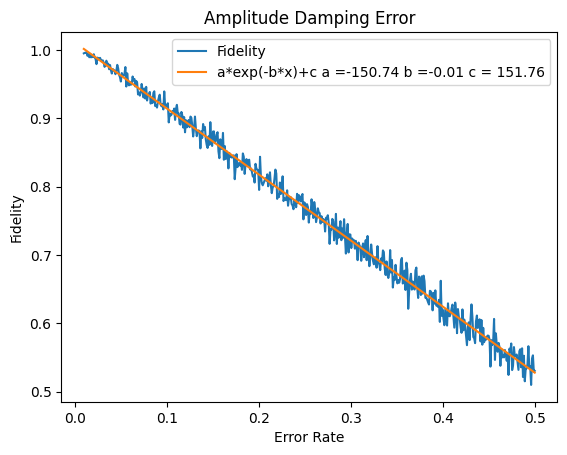

In [216]:
import matplotlib.pyplot as plt
import scipy

plt.plot(p_list,fidelities,label="Fidelity")
plt.title("Amplitude Damping Error")
plt.ylabel("Fidelity")
plt.xlabel("Error Rate")

def exp(x,a,b,c):
    return a*np.exp(-b*x)+c

popt, pcov  = scipy.optimize.curve_fit(exp,p_list,fidelities,maxfev=50000)

plt.plot(p_list,exp(np.array(p_list),*popt),label="a*exp(-b*x)+c" + " " + "a =" + f"{round(popt[0],2)}" + " b =" +  f"{round(popt[1],2)}" + " " +  "c = " +  f"{round(popt[2],2)}")
plt.legend()


In [35]:
print(preparing_for_battle_2(np.array([1,2,3,4,5,6,7,8])))

0: ──RY(2.35)─╭○─────╭●─────╭○─────╭○─────╭●─────╭●─────┤ ╭Probs
1: ───────────╰U(M0)─╰U(M1)─├○─────├●─────├○─────├●─────┤ ├Probs
2: ─────────────────────────╰U(M2)─╰U(M3)─╰U(M4)─╰U(M5)─┤ ╰Probs

M0 = 
[[ 0.40824829 -0.91287093]
 [ 0.91287093  0.40824829]]
M1 = 
[[ 0.5920935  -0.80586927]
 [ 0.80586927  0.5920935 ]]
M2 = 
[[ 0.4472136  -0.89442719]
 [ 0.89442719  0.4472136 ]]
M3 = 
[[ 0.6 -0.8]
 [ 0.8  0.6]]
M4 = 
[[ 0.6401844  -0.76822128]
 [ 0.76822128  0.6401844 ]]
M5 = 
[[ 0.65850461 -0.75257669]
 [ 0.75257669  0.65850461]]

[0.070014   0.14002801 0.21004201 0.28005602 0.35007002 0.42008403
 0.49009803 0.56011203]


In [25]:
def generate_tree(N):
    tree = []
    count = 0
    step = 0
    while count < N:
        tree.append(list(range(count, count+2**(step),1)))
        count += 2**(step)
        step +=1
    return tree 


def obtain_parent(tree, target_index):
    num, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)
    parent = tree[layer-1][int(np.ceil((position_index+1) / 2)) -1]
    return parent
    

def rearrange_qubits(tree):
    qubits = [0]*(tree[len(tree)-1][-1]+1)
    for i in range(len(tree)):
        temp = tree[len(tree)-i-1][::-1]
        for j in range(len(temp)):
            qubits[2**(i)+j*2**(i+1)-1] = temp[j]    
    return qubits



def nearest_tree_num(N):
    num = 1
    step = 1
    while num < N:
        num += 2**(step)
        step +=1

    return num, step    


def obtain_child_index(tree,target_index):
    child_indices =[]
    _, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)    
    child_indices.append(tree[layer+1][2*(position_index+1)-2])
    child_indices.append(tree[layer+1][2*(position_index+1)-1])
    return child_indices

def obtain_parent(tree, target_index):
    _, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)
    parent = tree[layer-1][int(np.ceil((position_index+1) / 2)) -1]
    return parent      



## 3) Complex Data Amplitude Embedding (Method 1)

In [44]:
def preparing_for_battle_3(x,dev,verbose=False):
  """
  Conduct Amplitude Embdding

  Args
    - x (numpy.tensor): a length-N vector

  Returns
    - state (qml.measurements.StateMP): Embedded state
  """

 

  x = x/np.linalg.norm(x)
  N = np.shape(x)[0]

  

  N_nearest = nearest_tree_num(N-1)[0]
  tree = generate_tree(N_nearest)
  qubits = rearrange_qubits(tree)
  

  x_new = np.zeros(N_nearest)
  x_new[:N] = x 

  def gen_angles(x):
    if len(x) > 1:
      new_x = [0]*int(len(x)/2)
      for k in range(len(new_x)):
        new_x[k] = np.sqrt(abs(x[2*k])**2+abs(x[2*k+1])**2)
      inner_angles = gen_angles(new_x)
      angles = [0] * int(len(x)/2)
      for k in range(len(new_x)):
        if new_x[k] !=0:
          if x[2*k]> 0:
            angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
          else:
            angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
        else:
          angles[k] = 0

      angles = angles + inner_angles
    elif len(x) == 1:
      angles = []

    return angles
  

  def gen_angles_z(x):
    if len(x) > 1:
      new_x = [0]*int(len(x)/2)
      
      for k in range(len(new_x)):
        new_x[k] = (x[2*k]+x[2*k+1])/2
        
    
      inner_angles_z = gen_angles_z(new_x)  

      angles_z = [0] * int(len(x)/2)
      for k in range(len(new_x)):
        angles_z[k] = x[2*k+1]-x[2*k]
        
   
      angles_z = inner_angles_z + angles_z

    elif len(x) == 1:
      angles_z = []
    return angles_z


  @qml.qnode(dev)
  def amplitude_embedding():

    angle = gen_angles(abs(x_new))

    phases = []

    for c in x_new:
      phases.append(np.angle(c))

    angle_z = gen_angles_z(phases)
    

    for k in range(len(angle)):
      qml.RY(angle[k],k)

    for k in range(len(angle_z)):
      qml.RZ(angle_z[k],k)

    tree = generate_tree(nearest_tree_num(N_nearest+1)[0])
    actual = obtain_parent(tree,N_nearest-1)
    while actual >=0:
      left_index = obtain_child_index(tree,actual)[0]
      right_index = obtain_child_index(tree,actual)[1]    
      while right_index < N_nearest:
        qml.CSWAP([qubits[actual],qubits[left_index],qubits[right_index]])
        left_index = obtain_child_index(tree,left_index)[0]
        right_index = obtain_child_index(tree,right_index)[0]
      actual = actual-1 

   

    return qml.probs(range(N_nearest))

  if verbose:
    print(qml.draw(amplitude_embedding)())
    print()
  state = np.sqrt(amplitude_embedding())
  return state

In [45]:
x = np.array([1,2,3,4,5,6,7])
N = int(np.shape(x)[0])
x_norm =x/np.linalg.norm(x)
x_density = np.outer(x_norm,x_norm)
N_nearest = nearest_tree_num(N)[0]
dev3 = qml.device("default.qubit",range(N_nearest))
result = preparing_for_battle_3(x,dev3,True)
result[result!=0]

0: ──RY(2.21)──RZ(0.00)───────╭SWAP───────╭SWAP─┤ ╭Probs
1: ──RY(1.85)──RZ(0.00)─╭SWAP─│───────────├SWAP─┤ ├Probs
2: ──RY(1.75)──RZ(0.00)─│─────├●────╭SWAP─│─────┤ ├Probs
3: ──RY(2.30)──RZ(0.00)─├SWAP─│─────│─────│─────┤ ├Probs
4: ─────────────────────│─────╰SWAP─│─────│─────┤ ├Probs
5: ─────────────────────╰●──────────├SWAP─│─────┤ ├Probs
6: ─────────────────────────────────╰●────╰●────┤ ╰Probs



tensor([0.07012869, 0.15681251, 0.08415442, 0.16830885, 0.18817501,
        0.37635003, 0.09350492, 0.20908335, 0.1122059 , 0.2244118 ,
        0.25090002, 0.50180004, 0.14025737, 0.31362502, 0.18700983,
        0.4181667 ], requires_grad=True)

In [74]:
def gen_angles(x):
    if len(x) > 1:
      new_x = [0]*int(len(x)/2)
      for k in range(len(new_x)):
        new_x[k] = np.sqrt(abs(x[2*k])**2+abs(x[2*k+1])**2)
      inner_angles = gen_angles(new_x)
      angles = [0] * int(len(x)/2)
      for k in range(len(new_x)):
        if new_x[k] !=0:
          if x[2*k]> 0:
            angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
          else:
            angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
        else:
          angles[k] = 0
      inner_angles = gen_angles(new_x)
      if inner_angles != None:
        angles = angles + inner_angles
      

      return angles   
    

In [75]:
gen_angles(x)

None
[tensor(2.30052398, requires_grad=True)]


[tensor(2.21429744, requires_grad=True),
 tensor(1.85459044, requires_grad=True),
 tensor(1.7521161, requires_grad=True),
 tensor(2.30052398, requires_grad=True)]